In [1]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')

In [2]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

23/05/02 18:52:08 WARN Utils: Your hostname, rig resolves to a loopback address: 127.0.1.1; using 192.168.0.102 instead (on interface enp6s0)
23/05/02 18:52:08 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/05/02 18:52:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# RDD to Spark DataFrame

In [3]:
sample_list = [('Mona', 20), ('Jennifer', 34), ('John', 20), ('Jim', 26)]
# Create an RDD from the list
rdd = sc.parallelize(sample_list)
# Create a PySpark DataFrame
names_df = spark.createDataFrame(rdd, schema=['Name', 'Age'])
# Check the type of names_df
print("The type of names_df is", type(names_df))

The type of names_df is <class 'pyspark.sql.dataframe.DataFrame'>


# Loading CSV into DataFrame

In [4]:
from pyspark.sql.types import *
schema = StructType(
    [
        StructField("_c0", IntegerType(), True),
        StructField("person_id", IntegerType(), True),
        StructField("name", StringType(), True),
        StructField("sex", StringType(), True),
        StructField("date of birth", DateType(), True),
    ]
)

In [5]:
# Create an DataFrame from file_path
people_df = spark.read.csv('people.csv', header=True, schema=schema)
# Check the type of people_df
print("The type of people_df is", type(people_df))

The type of people_df is <class 'pyspark.sql.dataframe.DataFrame'>


In [6]:
people_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- person_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- date of birth: date (nullable = true)



In [7]:
people_df.describe().show()

23/05/02 18:52:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/05/02 18:52:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , person_id, name, sex
 Schema: _c0, person_id, name, sex
Expected: _c0 but found: 
CSV file: file:///home/mauricio/code/big-data-with-pyspark/2-big-data-fundamentals-with-pyspark/people.csv


+-------+-----------------+-----------------+-------------+------+
|summary|              _c0|        person_id|         name|   sex|
+-------+-----------------+-----------------+-------------+------+
|  count|           100000|           100000|       100000| 98080|
|   mean|          49999.5|          50099.5|         null|  null|
| stddev|28867.65779668774|28867.65779668774|         null|  null|
|    min|                0|              100|Aaron Addesso|female|
|    max|            99999|           100099|  Zulma Biggs|  male|
+-------+-----------------+-----------------+-------------+------+



# Inspecting data in PySpark DataFrame

In [8]:
# Print the first 10 observations 
people_df.show(10)
# Count the number of rows 
print("There are {} rows in the people_df DataFrame.".format(people_df.count()))
# Count the number of columns and their names
print("There are {} columns in the people_df DataFrame and their names are {}".format(len(people_df.columns), people_df.columns))

23/05/02 18:52:13 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , person_id, name, sex, date of birth
 Schema: _c0, person_id, name, sex, date of birth
Expected: _c0 but found: 
CSV file: file:///home/mauricio/code/big-data-with-pyspark/2-big-data-fundamentals-with-pyspark/people.csv


+---+---------+----------------+------+-------------+
|_c0|person_id|            name|   sex|date of birth|
+---+---------+----------------+------+-------------+
|  0|      100|  Penelope Lewis|female|   1990-08-31|
|  1|      101|   David Anthony|  male|   1971-10-14|
|  2|      102|       Ida Shipp|female|   1962-05-24|
|  3|      103|    Joanna Moore|female|   2017-03-10|
|  4|      104|  Lisandra Ortiz|female|   2020-08-05|
|  5|      105|   David Simmons|  male|   1999-12-30|
|  6|      106|   Edward Hudson|  male|   1983-05-09|
|  7|      107|    Albert Jones|  male|   1990-09-13|
|  8|      108|Leonard Cavender|  male|   1958-08-08|
|  9|      109|  Everett Vadala|  male|   2005-05-24|
+---+---------+----------------+------+-------------+
only showing top 10 rows

There are 100000 rows in the people_df DataFrame.
There are 5 columns in the people_df DataFrame and their names are ['_c0', 'person_id', 'name', 'sex', 'date of birth']


## Spurious date

In [9]:
people_df.select('date of birth').groupby().agg({'date of birth': 'max'}).show(truncate=False)

+------------------+
|max(date of birth)|
+------------------+
|+20175-02-28      |
+------------------+



In [10]:
people_df = people_df.filter('`date of birth` < "20175"')

# PySpark DataFrame subsetting and cleaning

In [11]:
# Select name, sex and date of birth columns
people_df_sub = people_df.select('name', 'sex', 'date of birth')
# Print the first 10 observations from people_df_sub
people_df_sub.show(10)
# Remove duplicate entries from people_df_sub
people_df_sub_nodup = people_df_sub.dropDuplicates()
# Count the number of rows
print("There were {} rows before removing duplicates, and {} rows after removing duplicates".format(people_df_sub.count(), people_df_sub_nodup.count()))

+----------------+------+-------------+
|            name|   sex|date of birth|
+----------------+------+-------------+
|  Penelope Lewis|female|   1990-08-31|
|   David Anthony|  male|   1971-10-14|
|       Ida Shipp|female|   1962-05-24|
|    Joanna Moore|female|   2017-03-10|
|  Lisandra Ortiz|female|   2020-08-05|
|   David Simmons|  male|   1999-12-30|
|   Edward Hudson|  male|   1983-05-09|
|    Albert Jones|  male|   1990-09-13|
|Leonard Cavender|  male|   1958-08-08|
|  Everett Vadala|  male|   2005-05-24|
+----------------+------+-------------+
only showing top 10 rows

There were 98005 rows before removing duplicates, and 98005 rows after removing duplicates


# Filtering your DataFrame

In [12]:
# Filter people_df to select females 
people_df_female = people_df.filter(people_df.sex == "female")
# Filter people_df to select males
people_df_male = people_df.filter(people_df.sex == "male")
# Count the number of rows 
print("There are {} rows in the people_df_female DataFrame and {} rows in the people_df_male DataFrame".format(people_df_female.count(), people_df_male.count()))

There are 48049 rows in the people_df_female DataFrame and 48078 rows in the people_df_male DataFrame


# Running SQL Queries Programmatically

In [13]:
# Create a temporary table "people"
people_df.createOrReplaceTempView("people")
# Construct a query to select the names of the people from the temporary table "people"
query = '''SELECT name FROM people'''
# Assign the result of Spark's query to people_df_names
people_df_names = spark.sql(query)
# Print the top 10 names of the people
people_df_names.show(10)

+----------------+
|            name|
+----------------+
|  Penelope Lewis|
|   David Anthony|
|       Ida Shipp|
|    Joanna Moore|
|  Lisandra Ortiz|
|   David Simmons|
|   Edward Hudson|
|    Albert Jones|
|Leonard Cavender|
|  Everett Vadala|
+----------------+
only showing top 10 rows



# SQL queries for filtering Table

In [14]:
# Filter the people table to select female sex 
people_female_df = spark.sql('SELECT * FROM people WHERE sex=="female"')
# Filter the people table DataFrame to select male sex
people_male_df = spark.sql('SELECT * FROM people WHERE sex=="male"')
# Count the number of rows in both DataFrames
print("There are {} rows in the people_female_df and {} rows in the people_male_df DataFrames".format(people_female_df.count(), people_male_df.count()))

There are 48049 rows in the people_female_df and 48078 rows in the people_male_df DataFrames


# What is Data visualization?
Data visualization is a way of representing your data in graphs or charts
Open source plotting tools to aid visualization in Python:
Matplotlib, Seaborn, Bokeh etc.,
Plotting graphs using PySpark DataFrames is done using three methods
* `pyspark_dist_explore` library
* `toPandas()` method
* `HandySpark` library

In [15]:
people_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- person_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- date of birth: date (nullable = true)



array([[<Axes: title={'center': 'date of birth'}>]], dtype=object)

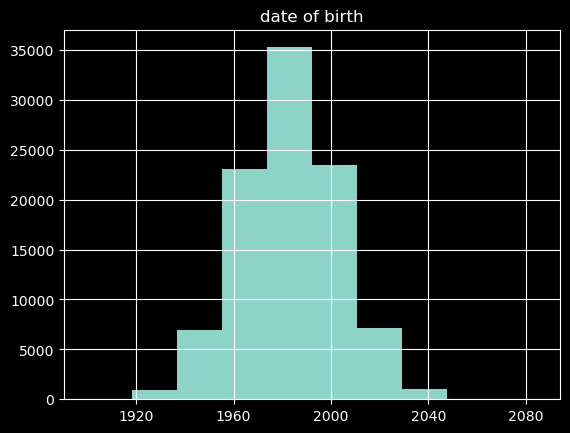

In [16]:
people_df.select('date of birth').toPandas().astype({'date of birth':'datetime64[ns]'}).hist()
# plt.show()

# PySpark DataFrame visualization

In [17]:
names_df = spark.read.csv('names.csv', header=True, inferSchema=True)
# Check the type of people_df
print("The type of people_df is", type(people_df))

The type of people_df is <class 'pyspark.sql.dataframe.DataFrame'>


In [18]:
names_df.show()

+--------+----+
|    Name| Age|
+--------+----+
|    Mona|20.0|
|Jennifer|34.0|
|    John|20.0|
|     Jim|26.0|
+--------+----+



In [19]:
names_df.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Age: double (nullable = true)



The column names of names_df are ['Name', 'Age']


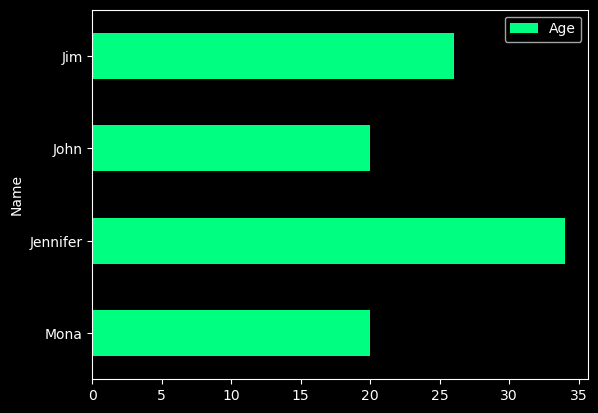

In [20]:
# Check the column names of names_df
print("The column names of names_df are", names_df.columns)
# Convert to Pandas DataFrame  
df_pandas = names_df.toPandas()
# Create a horizontal bar plot
df_pandas.plot(kind='barh', x='Name', y='Age', colormap='winter_r')
plt.show()

# Part 1: Create a DataFrame from CSV file

In [21]:
# Load the Dataframe
fifa_df = spark.read.csv('Fifa2018_dataset.csv', header=True, inferSchema=True)
# Check the schema of columns
fifa_df.printSchema()
# Show the first 10 observations
fifa_df.show(10)
# Print the total number of rows
print("There are {} rows in the fifa_df DataFrame".format(fifa_df.count()))

root
 |-- _c0: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Photo: string (nullable = true)
 |-- Nationality: string (nullable = true)
 |-- Flag: string (nullable = true)
 |-- Overall: integer (nullable = true)
 |-- Potential: integer (nullable = true)
 |-- Club: string (nullable = true)
 |-- Club Logo: string (nullable = true)
 |-- Value: string (nullable = true)
 |-- Wage: string (nullable = true)
 |-- Special: integer (nullable = true)
 |-- Acceleration: string (nullable = true)
 |-- Aggression: string (nullable = true)
 |-- Agility: string (nullable = true)
 |-- Balance: string (nullable = true)
 |-- Ball control: string (nullable = true)
 |-- Composure: string (nullable = true)
 |-- Crossing: string (nullable = true)
 |-- Curve: string (nullable = true)
 |-- Dribbling: string (nullable = true)
 |-- Finishing: string (nullable = true)
 |-- Free kick accuracy: string (nullable = true)
 |-- GK diving: string (nullable = true)


23/05/02 18:52:17 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Club Logo, Value, Wage, Special, Acceleration, Aggression, Agility, Balance, Ball control, Composure, Crossing, Curve, Dribbling, Finishing, Free kick accuracy, GK diving, GK handling, GK kicking, GK positioning, GK reflexes, Heading accuracy, Interceptions, Jumping, Long passing, Long shots, Marking, Penalties, Positioning, Reactions, Short passing, Shot power, Sliding tackle, Sprint speed, Stamina, Standing tackle, Strength, Vision, Volleys, CAM, CB, CDM, CF, CM, ID, LAM, LB, LCB, LCM, LDM, LF, LM, LS, LW, LWB, Preferred Positions, RAM, RB, RCB, RCM, RDM, RF, RM, RS, RW, RWB, ST
 Schema: _c0, Name, Age, Photo, Nationality, Flag, Overall, Potential, Club, Club Logo, Value, Wage, Special, Acceleration, Aggression, Agility, Balance, Ball control, Composure, Crossing, Curve, Dribbling, Finishing, Free kick accuracy, GK diving, GK ha

# Part 2: SQL Queries on DataFrame

In [22]:
# Create a temporary view of fifa_df
fifa_df.createOrReplaceTempView('fifa_df_table')
# Construct the "query"
query = '''SELECT Age FROM fifa_df_table WHERE Nationality == "Germany"'''
# Apply the SQL "query"
fifa_df_germany_age = spark.sql(query)
# Generate basic statistics
fifa_df_germany_age.describe().show()

+-------+-----------------+
|summary|              Age|
+-------+-----------------+
|  count|             1140|
|   mean|24.20263157894737|
| stddev|4.197096712293752|
|    min|               16|
|    max|               36|
+-------+-----------------+



# Part 3: Data visualization

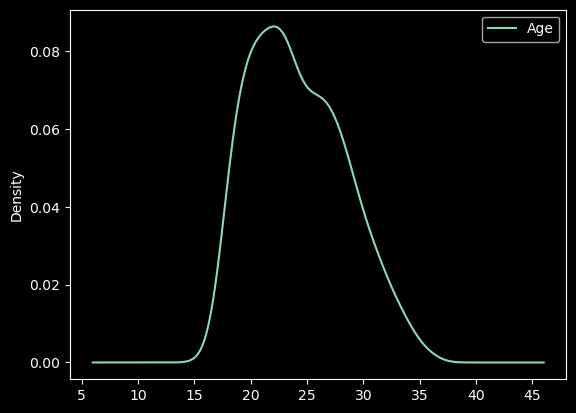

In [23]:
# Convert fifa_df to fifa_df_germany_age_pandas DataFrame
fifa_df_germany_age_pandas = fifa_df_germany_age.toPandas()

# Plot the 'Age' density of Germany Players
fifa_df_germany_age_pandas.plot(kind='density')
plt.show()